In [1]:
import glob
import cv2

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

from utilities.postprocessing.utils import *
from matplotlib import gridspec
from utilities.postprocessing.postprocessing import AddAdvancement
from utilities.postprocessing.utils import PatchExtractStrategy

class DataFrameVisualization():
    """
    Visualize a visualization dataframe
    """
    def __init__(self, df, *args, **kwargs):
        self.df = df

    def __call__(self, tr, time_window=None):
        if time_window is not None: self.df = AddAdvancement(time_window)((self.df, None, None))[0]
        self.plot_advancement()
        self.plot_advancement_box()
        self.plot_rotation()
        self.show_classes(tr)

    def plot_rotation(self):
        df = self.df
        fig = plt.figure()
        plt.title('rotation')
        ax1 = plt.subplot(3, 1, 1)
        ax2 = plt.subplot(3, 1, 2)
        ax3 = plt.subplot(3, 1, 3)
        ax1.set_title('yaw')
        df['pose__pose_e_orientation_x'].plot(ax=ax1)
        ax3.set_title('pitch')
        df['pose__pose_e_orientation_y'].plot(ax=ax2)
        ax3.set_title('roll')
        df['pose__pose_e_orientation_z'].plot(ax=ax3)
        plt.legend()
        plt.show()

    def plot_advancement(self):
        df = self.df
        fig = plt.figure()
        plt.title('advancement')
        df['advancement'].plot.line()
        plt.show()

    def plot_advancement_box(self):
        fig = plt.figure()
        plt.title('advancement box')
        self.df['advancement'].plot.box()
        plt.show()

    def show_classes(self, tr):
        df = self.df
        fig = plt.figure()
        if tr is not None: temp = df['advancement'] > tr
        else: temp = df['label']

        plt.title("tr={:3f}".format(tr))

        temp.value_counts().plot.bar()
        plt.show()


    @classmethod
    def from_root(cls, root, *args, **kwargs):
        dfs_paths = glob.glob(root + '/*.csv')
        if len(dfs_paths) <= 0: dfs_paths = glob.glob(root + '/**/*.csv')
        dfs = [pd.read_csv(df_paths) for df_paths in dfs_paths]
        return cls.from_dfs(dfs, *args, **kwargs)

    @classmethod
    def from_dfs(cls, dfs, *args, **kwargs):

        df_total = pd.concat(dfs, sort=False)
        df_total = df_total.dropna()
        df_total = df_total.reset_index(drop=True)

        return cls(df_total, *args, **kwargs)

    @classmethod
    def from_df_path(cls, df_path, *args, **kwargs):
        return cls(pd.read_csv(df_path), *args, **kwargs)


def find_tr(df):
    return df['advancement'].mean() / 2

/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [4]:
def hmread(path):
    hm = cv2.imread(path)
    hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)
    return hm

In [74]:

class PatchesAndDataframeVisualization(DataFrameVisualization):
    def __init__(self, df, hm, max_advancement=1, image_dir=None, patch_extractor=PatchExtractStrategy, *args, **kwargs):
        super().__init__(df, *args, **kwargs)
        self.hm = hm
        self.max_advancement = max_advancement
        self.image_dir = image_dir
        self.patch_extractor = patch_extractor(max_advancement)
        dummy_path, _ = self.patch_extractor(hm, hm.shape[0]//2, hm.shape[1]//2, 0)
        self.patch_size = dummy_path.shape
    @property
    def hm_ax(self):
        fig = plt.figure()
        ax = sns.heatmap(self.hm)
        return ax

    def show_patches(self, center=False, n_samples=4, scale=1, random_state=0, sample=None):
        df = self.df
        # sample = df.sample(n_samples, random_state=random_state)
        if sample is None: sample = df[:n_samples]

        fig, ax = plt.subplots(nrows=n_samples // 2, ncols=n_samples // 2)
        fig.suptitle('patches center={}'.format(center))
        for row in ax:
            for idx, (col, (i, row)) in enumerate(zip(row, sample.iterrows())):
                x, y = row["hm_x"], row["hm_y"]
                patch, corners = self.patch_extractor(self.hm, x, y, np.rad2deg(row['pose__pose_e_orientation_z']))
                patch = patch.astype(np.float32)
#                 if center: patch = patch - patch[patch.shape[0] // 2, patch.shape[1] // 2]
#                 col.plot(self.patch_size[0] // 2, self.patch_size[1] // 2, marker='o', color='r', ls='', linewidth=10,
#                          label='finish')
                col.set_title(row['advancement'])
                sns.heatmap(patch, ax=col)

        plt.show()


    def show_traces(self, dfs, ax=None):
        if ax is None: ax = self.hm_ax

        start_marker = mlines.Line2D([], [], marker='o', color='g', ls='', label='start')
        finish_marker = mlines.Line2D([], [], marker='o', color='r', ls='', label='finish')

        for df in dfs:
            initial_pos = df.hm_x.iloc[0], df.hm_y.iloc[0]
            last_position = df.hm_x.iloc[-1], df.hm_y.iloc[-1]
            ax.plot(*initial_pos, marker='o', color='g', ls='', label='start')
            ax.plot(*last_position, marker='o', color='r', ls='', label='finish')
            ax.plot(df.hm_x, df.hm_y, '--', linewidth=2, color='white', label='path')

        ax.legend(handles=[start_marker, finish_marker])
        return ax



    def show_labeled_patches(self, tr=None):
        df = self.df
        # useful if we want to test an other tr on the fly
        df['label'] = df['advancement'] > tr
        tmp = df.loc[df['label'] == True]

        sample = tmp.sort_values("advancement", ascending=False).head(4)

        self.show_patches_on_the_map(df=sample, title='true', compress=False)

        plt.show()

        tmp = df[df['label'] == False]

        sample = tmp.sort_values("advancement", ascending=False).tail(4)

        self.show_patches_on_the_map(df=sample, title='false', compress=False)

        plt.show()

    def plot_box_on_hm(self, row):
        fig = plt.figure()
        ax = plt.gca()
        x, y, ang, ad = row["hm_x"], \
                        row["hm_y"], \
                        row["pose__pose_e_orientation_z"], \
                        row["advancement"]

        sns.heatmap(self.hm / 255, vmin=0, vmax=1, ax=ax)

        rect = mpatches.Rectangle((x - self.patch_size // 2, y - self.patch_size // 2), self.patch_size,
                                  self.patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()


    def plot_patch_map_advancement_in_time(self):
        df = self.df
        fig = plt.figure(figsize=(8, 8))

        plt.ion()

        patch_size = 92

        gridspec.GridSpec(2, 2)

        fig.show()
        fig.canvas.draw()

        for i, row in df.iterrows():
            ax_ad = plt.subplot2grid((2, 2), (0, 0), colspan=2, rowspan=1)

            ax_ad.plot(df['advancement'][:i])

            #         ax = plt.subplot2grid((2,2), (1, 0), colspan=1, rowspan=1)
            patch = cv2.imread(self.image_dir + row.loc['images'])
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

            ax_patch = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
            sns.heatmap(patch / 255, vmin=0, vmax=1, ax=ax_patch)

            x, y, ang, ad = row["hm_x"], \
                            row["hm_y"], \
                            row["pose__pose_e_orientation_z"], \
                            row["advancement"]


            ax_hm = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
            sns.heatmap(self.hm / 255, vmin=0, vmax=1, ax=ax_hm)

            rect = mpatches.Rectangle((x - self.patch_size // 2, y - self.patch_size  // 2), self.patch_size ,
                                      self.patch_size , linewidth=1, edgecolor='r', facecolor='none')
            ax_hm.add_patch(rect)

            fig.canvas.draw()
            plt.pause(0.025)


    def show_classes(self, tr, df=None):
        if df is None : df = self.df

        fig = plt.figure()

        if tr is not None: temp = df['advancement'] > tr
        else: temp = df['label']

        temp.value_counts().plot.bar()
        plt.show()


    @classmethod
    def from_df_path(cls, df_path, hm_dir, *args, **kwargs):
        df = pd.read_csv(df_path)
        map_name = df['map_name'][0]

        hm = cv2.imread(glob.glob('{}/**/{}.png'.format(hm_dir, map_name))[0])
        hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)

        return cls(df=df, hm=hm, *args, **kwargs)
            
    
    def show_patches_on_the_map(self, n_show=4, title='patches', compress=True, df=None, res=0.02):
        if df is None : df = self.df
        fig = plt.figure(figsize=(4 * 2, 4 * 3))
        size = (2 + n_show // 2, n_show // 2)
        gridspec.GridSpec(*size)

        ax_hm = plt.subplot2grid((size), (0, 0), colspan=2, rowspan=2)
        ax_hm.set_title(title)
        sns.heatmap(self.hm / 255, ax=ax_hm, vmin=0, vmax=1)

        self.show_traces([df], ax=ax_hm)

        if compress:
            df = df.loc[list(range(0, len(df), len(df) // n_show)), :]

        hm_patches = []
        for i, row in df.iterrows():
            x, y, ang, ad = row["hm_x"], \
                            row["hm_y"], \
                            row["pose__pose_e_orientation_z"], \
                            row["advancement"]
            patch, corners = self.patch_extractor(self.hm, x, y, np.rad2deg(ang))
            
            ax_hm.fill(corners[[0,1,2,3,0],0],corners[[0,1,2,3,0],1], alpha=0.2,
                       facecolor='r')

#             rect = mpatches.Rectangle(corners[4], self.patch_size[0],  self.patch_size[1], np.rad2deg(ang), linewidth=1, edgecolor='r', facecolor='none')
#             ax_hm.add_patch(rect)
#             circ = plt.Circle((x, y), radius=2, color='r')
#             ax_hm.add_patch(circ)

            # disable axis number
#             ax_hm.get_yaxis().set_visible(False)
#             ax_hm.get_xaxis().set_visible(False)


            patch = patch.astype(np.float32)
            patch = patch - patch[patch.shape[0] // 2, patch.shape[1] // 2]
            hm_patches.append((patch, ad))

        for i in range(n_show // 2):
            for j in range(n_show // 2):
                ax_patch = plt.subplot2grid((size), (2 + i, j), colspan=1, rowspan=1)
                patch, ad = hm_patches[i + j]
                sns.heatmap(patch, ax=ax_patch)
                ax_patch.set_title('{:.3f}'.format(ad))

                # disable axis number
#                 ax_patch.get_yaxis().set_visible(False)
#                 ax_patch.get_xaxis().set_visible(False)

        plt.show()

<IPython.core.display.Javascript object>


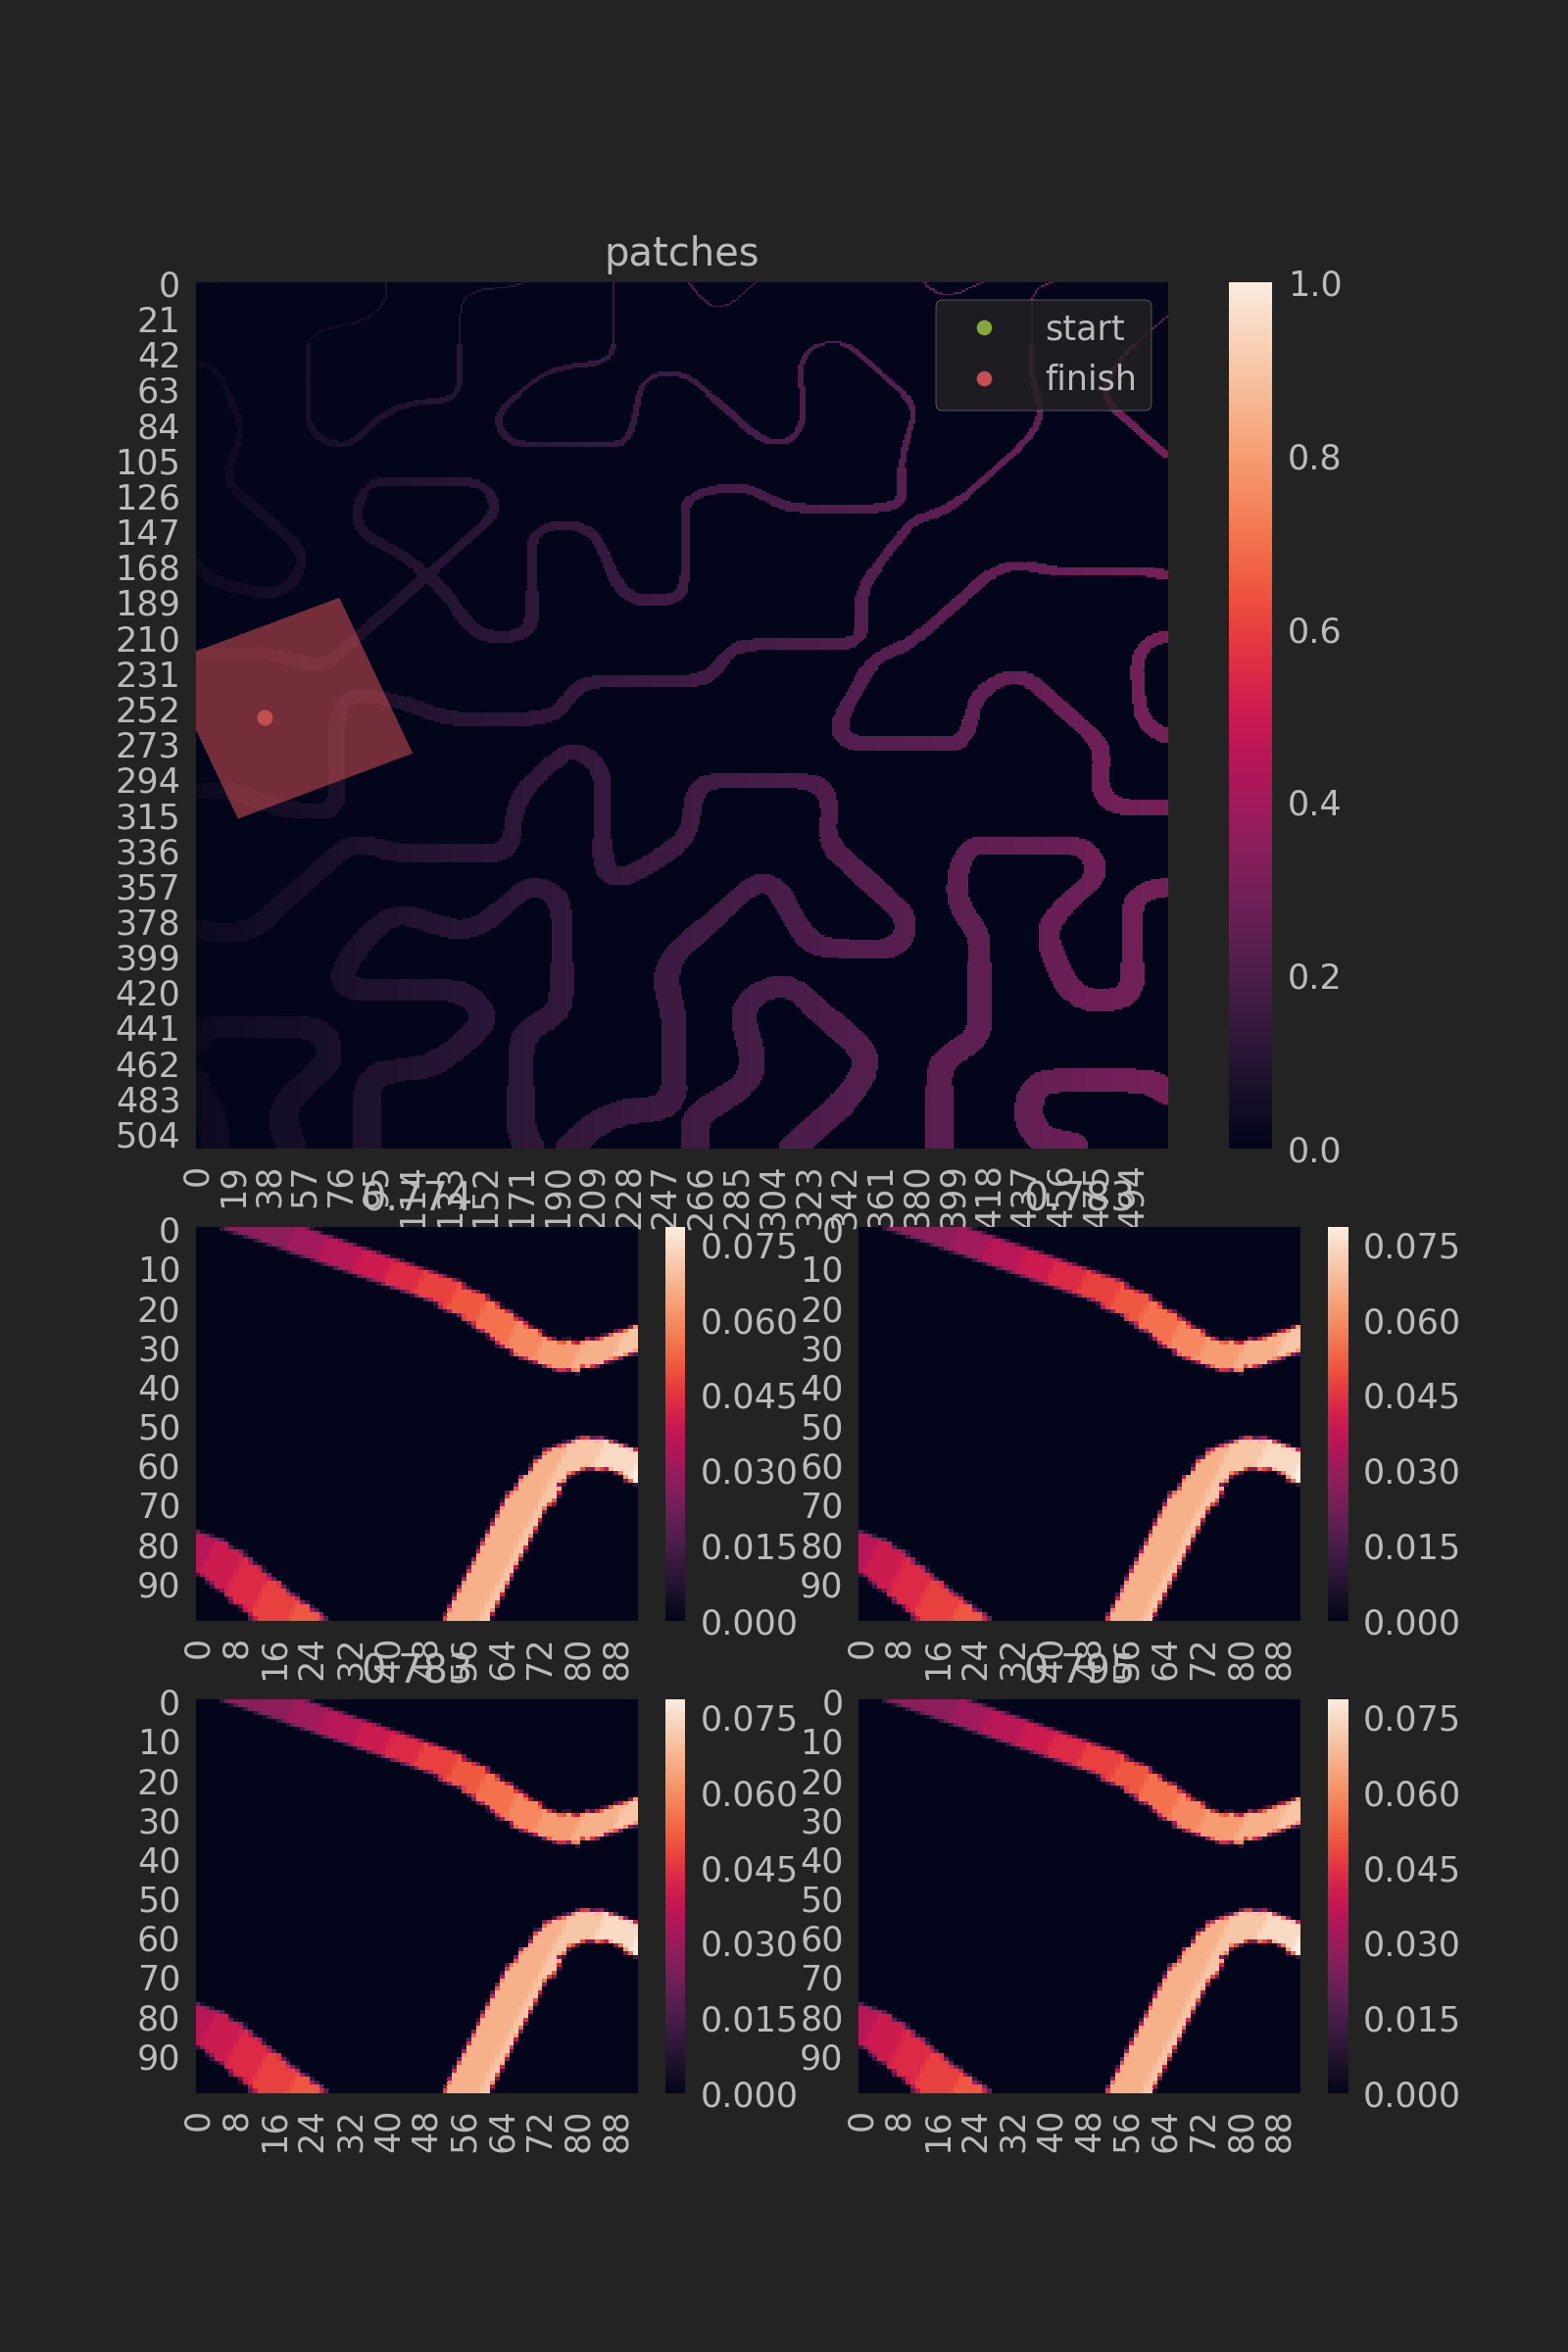

In [75]:
%matplotlib notebook
df_vis = PatchesAndDataframeVisualization(df,hm, patch_extractor=KrockPatchExtractStrategy)
df_vis.show_patches_on_the_map(df=df_vis.df[0:4], compress=False)

In [26]:
df_base_dir = '/media/francesco/saetta/krock-dataset/train/csvs_patches/'
meta = pd.read_csv('/media/francesco/saetta/krock-dataset/train/bags/meta.csv')
meta = meta[meta['map'] == 'bars1']
hm_dir = '/media/francesco/saetta/krock-dataset/train/patches/'

In [27]:
df = pd.read_csv('{}/{}.csv'.format(df_base_dir, meta['filename'].iloc[0]))
# for some reason map name is missing
df['map_name'] = 'bars1'
hm = hmread('./maps/train/bars1.png')

In [42]:
df_vis = PatchesAndDataframeVisualization(df,hm, patch_extractor=KrockPatchExtractStrategy)

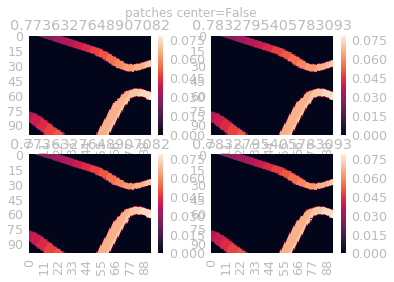

In [43]:
df_vis.show_patches()

In [76]:
from utilities.pipeline import *

In [86]:
from functools import partial

def power(a):
    def inner(x):
        print(x)
        return x ** a
    
    return inner

power2 = power(2)
power3 = power(3)
power4 = power(4)

ForEachApply([power2, power3, power4])([2,2,2])

2
4
64
2
4
64
2
4
64


[16777216, 16777216, 16777216]